# Ray Marching Algorithm for Edge-Based Voronoi Diagrams

This notebook demonstrates the complete ray marching algorithm for computing edge-based Voronoi diagrams in 2D.

## Algorithm Overview

1. **Start from vertices**: Each vertex of the polygons emits a ray
2. **Compute normals**: Ray direction is the average of incident edge normals
3. **March rays**: Move rays step-by-step in parallel
4. **Detect collisions**: Check when rays get close to each other
5. **Compute intersections**: Find exact intersection points
6. **Build graph**: Construct Voronoi graph from intersections
7. **Extract cells**: Determine which Voronoi vertices belong to which edge

Each polygon **edge** gets its own Voronoi cell (not vertices!).


In [34]:
# Reload modules to get latest changes
import sys
import importlib

# Remove cached modules
if 'analytic_inr' in sys.modules:
    del sys.modules['analytic_inr']
if 'analytic_inr.ray_marching_voronoi' in sys.modules:
    del sys.modules['analytic_inr.ray_marching_voronoi']

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import LineCollection
import torch

from analytic_inr import RayMarchingVoronoi, polygons_to_tensor_list

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Modules reloaded!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'cuda' if torch.cuda.is_available() else 'cpu'}")


Modules reloaded!
PyTorch version: 2.9.0+cu128
Device available: cuda


## Step 1: Define Input Polygons

We'll create a simple set of non-overlapping polygons to demonstrate the algorithm.


Polygon ordering verification:
  Triangle: CCW ✓
  Quad: CCW ✓
  Pentagon: CCW ✓


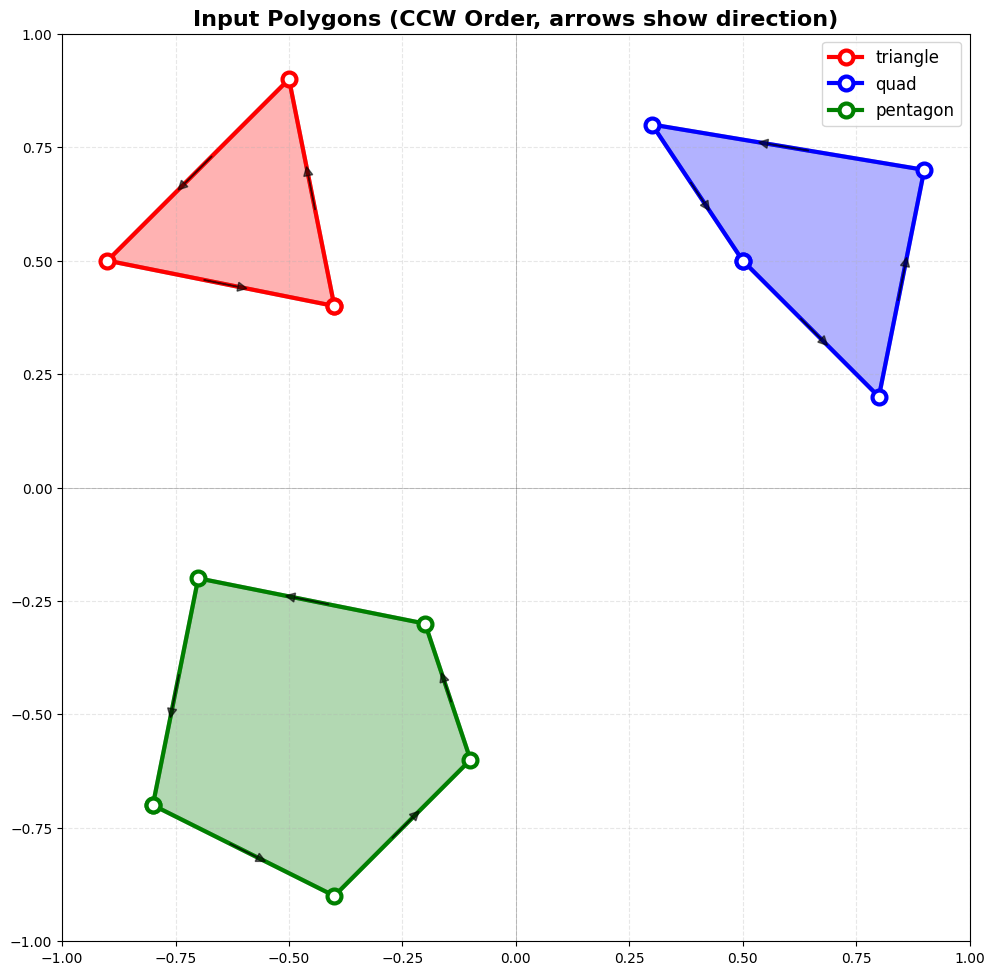


Total shapes: 3
Total vertices: 12
Total edges: 12


In [35]:
def check_ccw(vertices):
    """Check if polygon vertices are in counter-clockwise order using signed area."""
    n = len(vertices)
    signed_area = 0.0
    for i in range(n):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % n]
        signed_area += (x1 * y2 - x2 * y1)
    return signed_area > 0

def ensure_ccw(vertices):
    """Ensure vertices are in CCW order, reverse if needed."""
    if check_ccw(vertices):
        return vertices
    else:
        return np.ascontiguousarray(vertices[::-1])

# Define three simple polygons (triangle, quad, pentagon)
triangle = np.array([
    [-0.9, 0.5],
    [-0.5, 0.9],
    [-0.4, 0.4]
])

quad = np.array([
    [0.3, 0.8],
    [0.9, 0.7],
    [0.8, 0.2],
    [0.5, 0.5]
])

pentagon = np.array([
    [-0.7, -0.2],
    [-0.2, -0.3],
    [-0.1, -0.6],
    [-0.4, -0.9],
    [-0.8, -0.7]
])

# Ensure all polygons are CCW
triangle = ensure_ccw(triangle)
quad = ensure_ccw(quad)
pentagon = ensure_ccw(pentagon)

print("Polygon ordering verification:")
print(f"  Triangle: {'CCW ✓' if check_ccw(triangle) else 'CW (fixed)'}")
print(f"  Quad: {'CCW ✓' if check_ccw(quad) else 'CW (fixed)'}")
print(f"  Pentagon: {'CCW ✓' if check_ccw(pentagon) else 'CW (fixed)'}")

shapes = {
    'triangle': triangle,
    'quad': quad,
    'pentagon': pentagon
}

colors = {'triangle': 'red', 'quad': 'blue', 'pentagon': 'green'}

# Visualize input polygons
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for shape_name, vertices in shapes.items():
    polygon = MplPolygon(vertices, facecolor=colors[shape_name], 
                        edgecolor='black', alpha=0.3, linewidth=3)
    ax.add_patch(polygon)
    
    closed_verts = np.vstack([vertices, vertices[0]])
    ax.plot(closed_verts[:, 0], closed_verts[:, 1], 'o-', 
            color=colors[shape_name], linewidth=3, markersize=10,
            label=shape_name, markerfacecolor='white', 
            markeredgewidth=3, markeredgecolor=colors[shape_name])
    
    # Draw arrows to show CCW direction
    for i in range(len(vertices)):
        v1 = vertices[i]
        v2 = vertices[(i + 1) % len(vertices)]
        mid = (v1 + v2) / 2
        direction = (v2 - v1) * 0.15
        ax.arrow(mid[0] - direction[0]/2, mid[1] - direction[1]/2, 
                direction[0], direction[1],
                head_width=0.02, head_length=0.02, fc='black', ec='black', 
                linewidth=1, alpha=0.6, zorder=10)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=0, color='k', linewidth=0.5, alpha=0.3)
ax.axvline(x=0, color='k', linewidth=0.5, alpha=0.3)
ax.legend(loc='upper right', fontsize=12)
ax.set_title('Input Polygons (CCW Order, arrows show direction)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTotal shapes: {len(shapes)}")
print(f"Total vertices: {sum(len(v) for v in shapes.values())}")
print(f"Total edges: {sum(len(v) for v in shapes.values())}")


## Step 2: Initialize Ray Marching Voronoi

Create the `RayMarchingVoronoi` object which extracts the graph structure.


In [36]:
# Convert to list of tensors
polygon_list = [
    torch.tensor(triangle, dtype=torch.float32),
    torch.tensor(quad, dtype=torch.float32),
    torch.tensor(pentagon, dtype=torch.float32)
]

# Initialize
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

voronoi = RayMarchingVoronoi(polygon_list, device=device)

print(f"\nGraph structure extracted:")
print(f"  Vertices: {voronoi.vertices.shape}")
print(f"  Edges: {voronoi.edges.shape}")
print(f"  Vertex-to-edges mapping: {len(voronoi.vertex_to_edges)} vertices")


Using device: cuda

Graph structure extracted:
  Vertices: torch.Size([12, 2])
  Edges: torch.Size([12, 2, 2])
  Vertex-to-edges mapping: 12 vertices


## Step 3: Compute Vertex Normals

Each vertex emits a ray in the direction of the averaged normal of its incident edges.

**For CCW-ordered polygons:**
- At each vertex, we have an **incoming edge** (from previous vertex) and an **outgoing edge** (to next vertex)
- For each edge with direction `(dx, dy)`, the outward normal is `(-dy, dx)` (90° counter-clockwise rotation)
- We average the normals of both incident edges and normalize
- This gives us the correct outward-pointing direction for ray marching


Computed normals for 12 vertices

Normal vectors (should point outward from polygons):
  Vertex 0 at [-0.400, 0.400]: normal = [-0.707, 0.707]
  Vertex 1 at [-0.500, 0.900]: normal = [-0.290, -0.957]
  Vertex 2 at [-0.900, 0.500]: normal = [0.957, 0.290]
  Vertex 3 at [0.500, 0.500]: normal = [0.773, 0.634]
  Vertex 4 at [0.800, 0.200]: normal = [-0.290, 0.957]


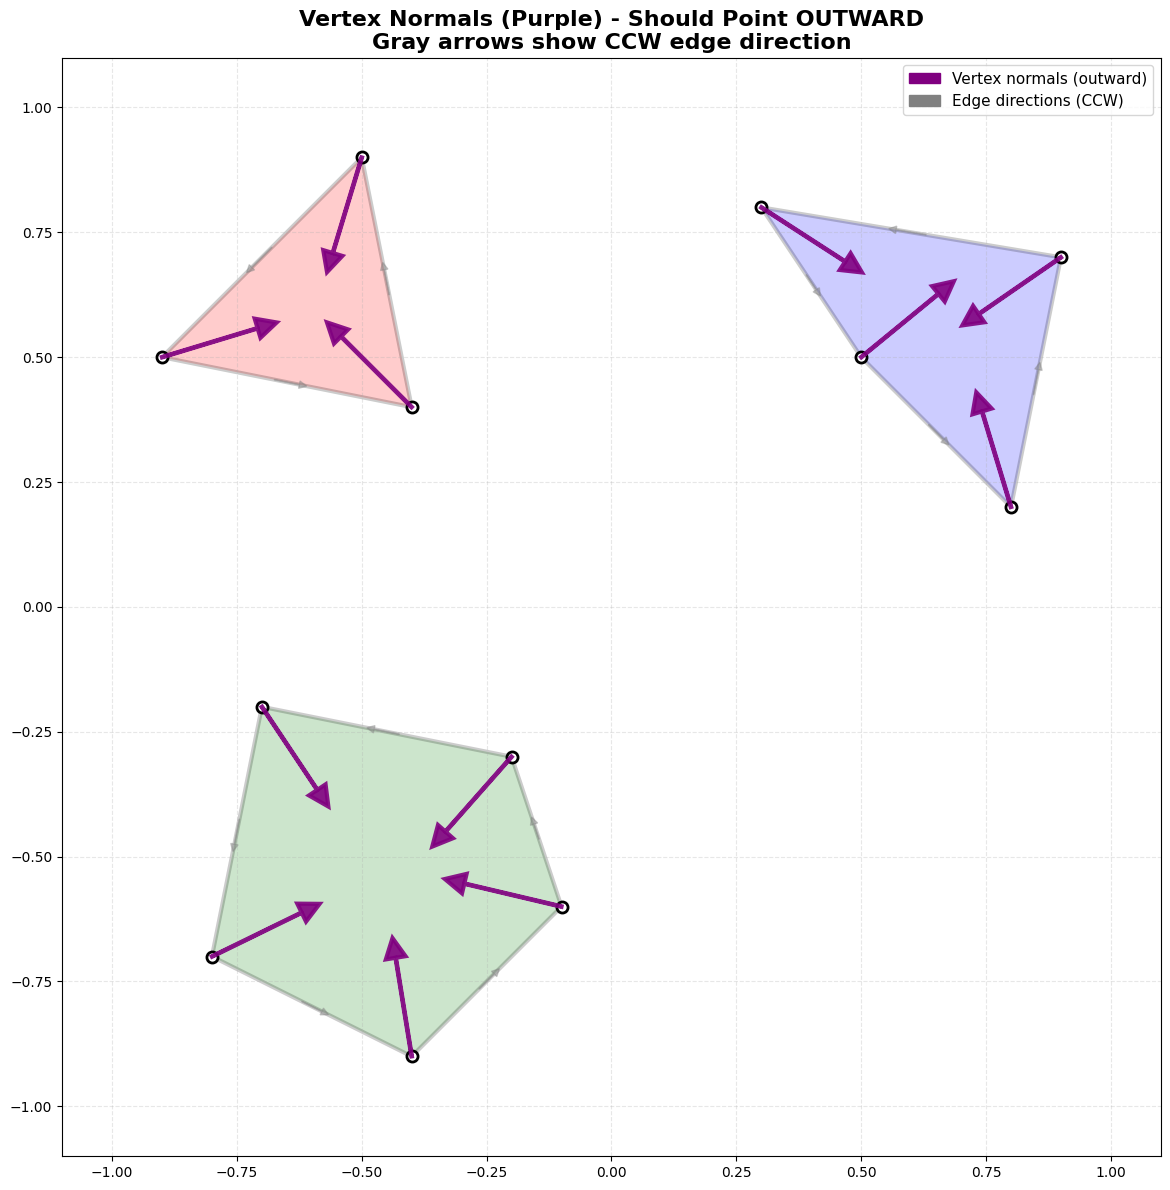

In [37]:
# Compute normals
normals = voronoi.compute_vertex_normals()

print(f"Computed normals for {normals.shape[0]} vertices")
print("\nNormal vectors (should point outward from polygons):")
for i in range(min(5, normals.shape[0])):
    v = voronoi.vertices[i].cpu().numpy()
    n = normals[i].cpu().numpy()
    print(f"  Vertex {i} at [{v[0]:.3f}, {v[1]:.3f}]: normal = [{n[0]:.3f}, {n[1]:.3f}]")

# Visualize normals
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Draw polygons with edges highlighted
for shape_name, vertices in shapes.items():
    polygon = MplPolygon(vertices, facecolor=colors[shape_name], 
                        edgecolor='black', alpha=0.2, linewidth=3)
    ax.add_patch(polygon)
    
    # Draw edge directions (to verify CCW)
    for i in range(len(vertices)):
        v1 = vertices[i]
        v2 = vertices[(i + 1) % len(vertices)]
        mid = (v1 + v2) / 2
        direction = (v2 - v1) * 0.1
        ax.arrow(mid[0] - direction[0]/2, mid[1] - direction[1]/2, 
                direction[0], direction[1],
                head_width=0.015, head_length=0.015, fc='gray', ec='gray', 
                linewidth=1, alpha=0.4, zorder=5)

# Draw vertices
vertices_np = voronoi.vertices.cpu().numpy()
ax.plot(vertices_np[:, 0], vertices_np[:, 1], 'ko', 
       markersize=8, zorder=10, markerfacecolor='white',
       markeredgewidth=2)

# Draw normals as arrows (should point OUTWARD from polygon)
normals_np = normals.cpu().numpy()

for i in range(len(vertices_np)):
    v = vertices_np[i]
    n = normals_np[i] * 0.2  # Scale for visibility
    ax.arrow(v[0], v[1], n[0], n[1], 
            head_width=0.04, head_length=0.04, 
            fc='purple', ec='purple', linewidth=3, alpha=0.9, zorder=15)

ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_title('Vertex Normals (Purple) - Should Point OUTWARD\nGray arrows show CCW edge direction', 
            fontsize=16, fontweight='bold')

# Add legend
from matplotlib.patches import FancyArrow
legend_elements = [
    FancyArrow(0, 0, 0.1, 0, width=0.02, facecolor='purple', edgecolor='purple', 
              label='Vertex normals (outward)'),
    FancyArrow(0, 0, 0.1, 0, width=0.01, facecolor='gray', edgecolor='gray',
              label='Edge directions (CCW)')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()


## Step 4: Create Boundary-to-Boundary Segments

Instead of ray marching, we create line segments through each vertex along its normal direction.
Each segment extends from the domain boundary to the domain boundary (going through the vertex in both directions).



Creating boundary-to-boundary segments...
  Domain: [-1, 1]^2
  Created 12 segments

Boundary Segments Created:
Number of segments: 12
Each segment goes through a vertex along its normal


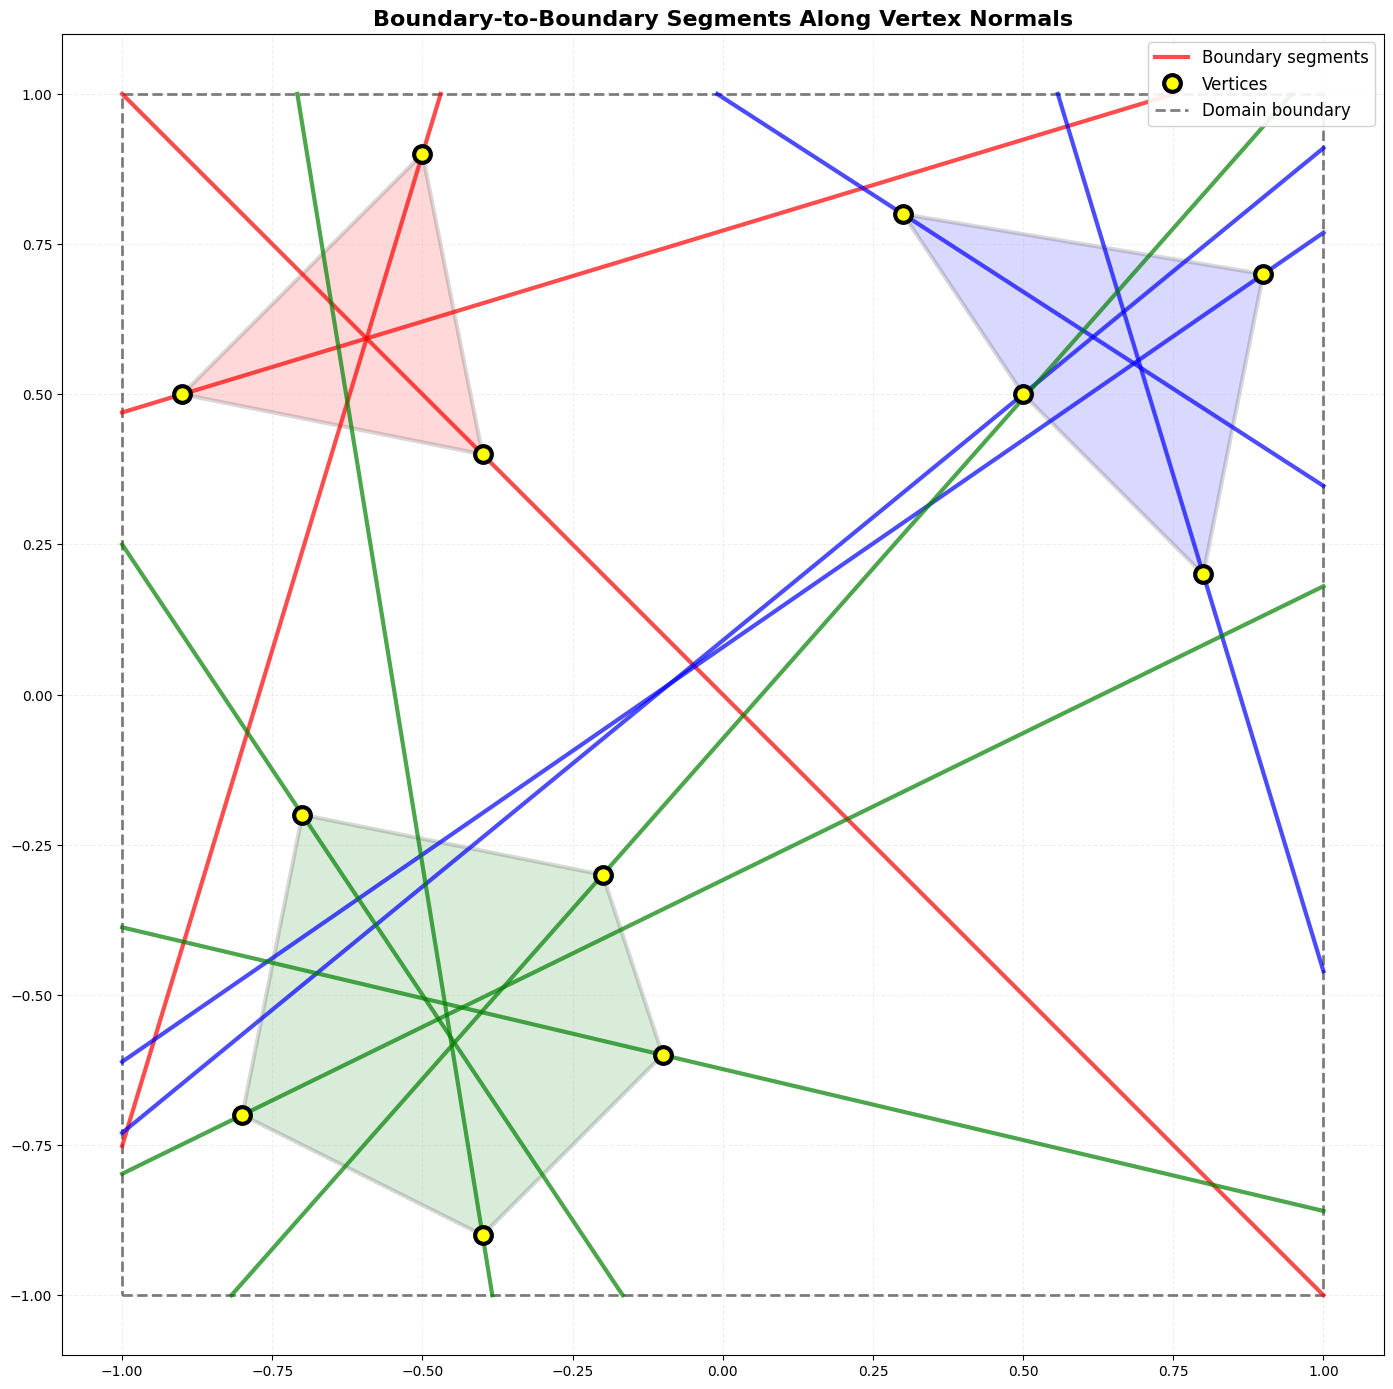

In [38]:
# Create boundary-to-boundary segments
segments_data = voronoi.create_boundary_segments(bounds=(-1, 1))

print(f"\n{'='*60}")
print(f"Boundary Segments Created:")
print(f"{'='*60}")
print(f"Number of segments: {len(segments_data['segments'])}")
print(f"Each segment goes through a vertex along its normal")

# Visualize the segments
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

# Draw polygons
for shape_name, vertices in shapes.items():
    polygon = MplPolygon(vertices, facecolor=colors[shape_name], 
                        edgecolor='black', alpha=0.15, linewidth=3)
    ax.add_patch(polygon)

# Draw boundary segments (thick lines)
for idx, (start, end) in enumerate(segments_data['segments']):
    start_np = start.cpu().numpy()
    end_np = end.cpu().numpy()
    v_idx = segments_data['vertex_indices'][idx]
    
    # Use different colors for different polygons
    if v_idx < 3:  # triangle
        color = 'red'
    elif v_idx < 7:  # quad
        color = 'blue'
    else:  # pentagon
        color = 'green'
    
    label = None if idx > 0 else 'Boundary segments'
    ax.plot([start_np[0], end_np[0]], [start_np[1], end_np[1]], '-',
           color=color, linewidth=3, alpha=0.7, label=label, zorder=5)

# Draw vertices
vertices_np = voronoi.vertices.cpu().numpy()
ax.plot(vertices_np[:, 0], vertices_np[:, 1], 'ko', 
       markersize=12, zorder=10, markerfacecolor='yellow',
       markeredgewidth=3, label='Vertices')

# Draw domain boundary
ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k--', 
       linewidth=2, alpha=0.5, label='Domain boundary')

ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_aspect('equal')
ax.grid(True, alpha=0.2, linestyle='--')
ax.legend(loc='upper right', fontsize=12, framealpha=0.9)
ax.set_title('Boundary-to-Boundary Segments Along Vertex Normals', 
            fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


## Step 5: Find Segment Intersections

Find all intersections between the boundary segments.
For each vertex, identify the closest intersection point.



Finding segment intersections (nearest in each direction)...
  Found 19 Voronoi vertices
  (9 vertices × 2 directions)

Intersection Results:
Voronoi vertices found: 19
Vertices with intersections: 12


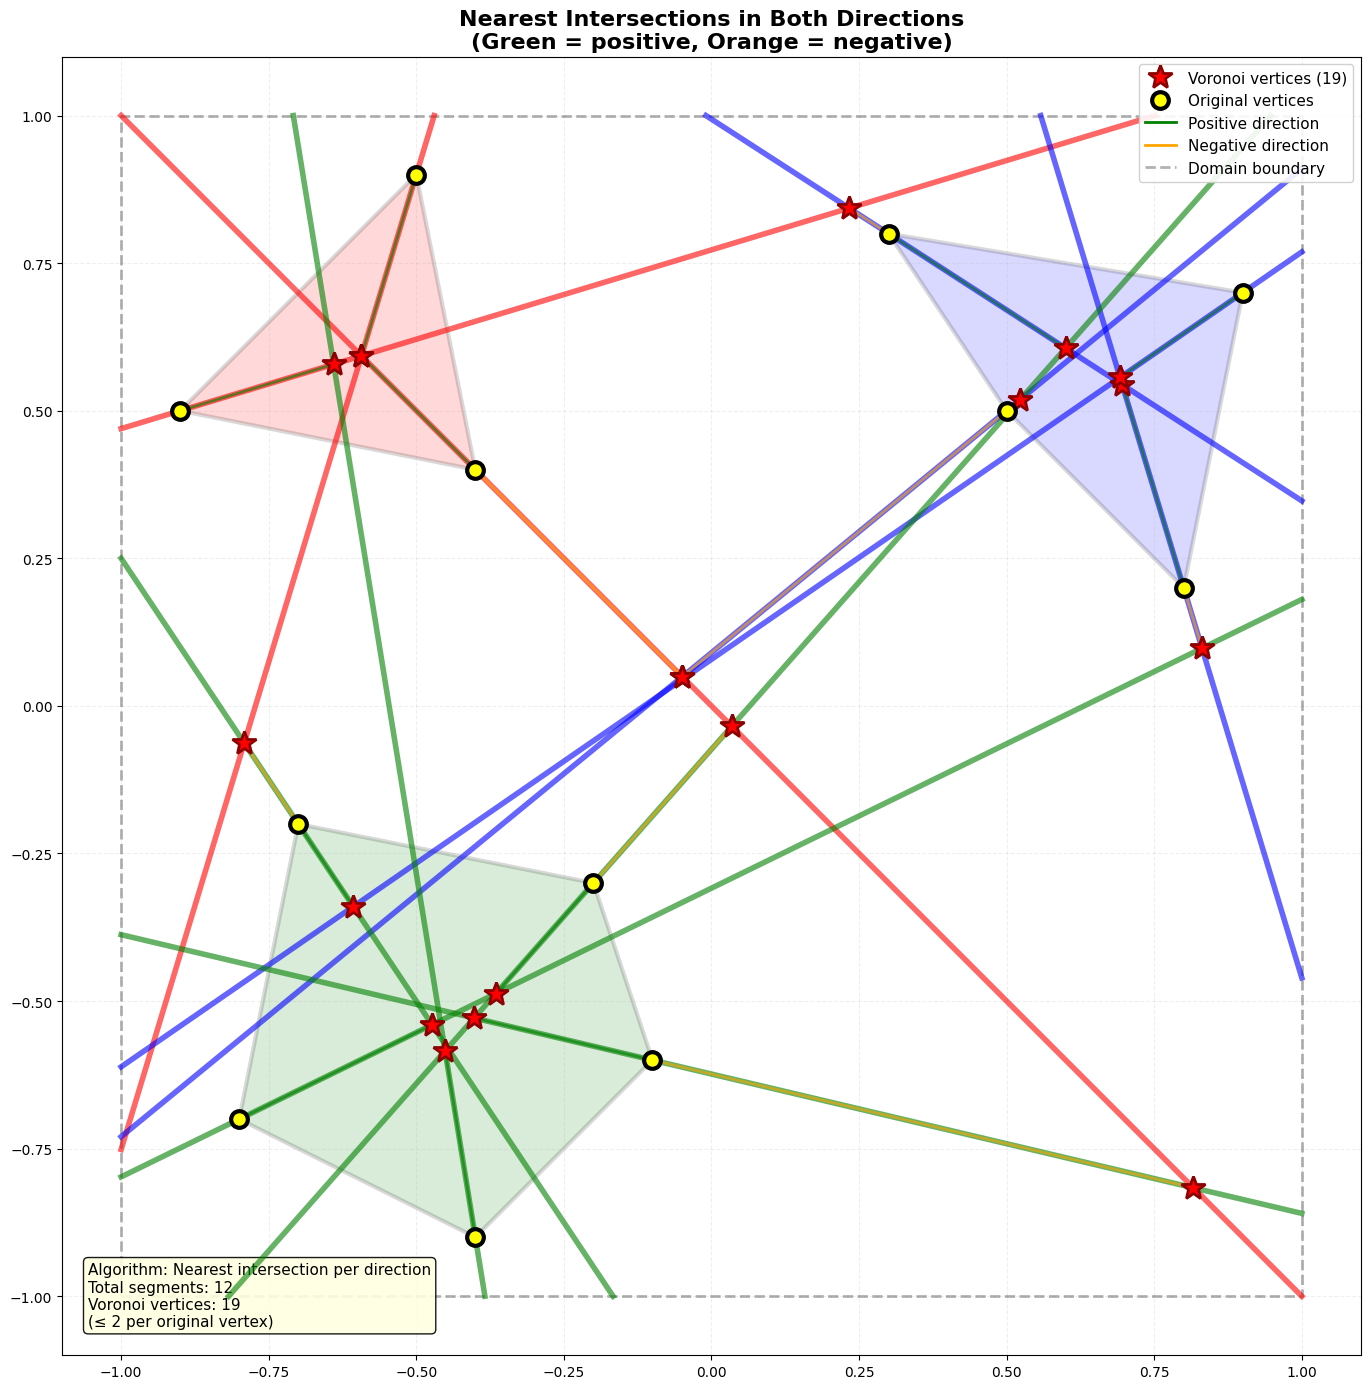

In [39]:
# Find segment intersections (nearest in each direction)
intersection_data = voronoi.find_segment_intersections(segments_data)

print(f"\n{'='*60}")
print(f"Intersection Results:")
print(f"{'='*60}")
print(f"Voronoi vertices found: {len(intersection_data['voronoi_vertices'])}")
print(f"Vertices with intersections: {len(intersection_data['vertex_to_voronoi'])}")

# Visualize intersections
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

# Draw polygons
for shape_name, vertices in shapes.items():
    polygon = MplPolygon(vertices, facecolor=colors[shape_name], 
                        edgecolor='black', alpha=0.15, linewidth=3)
    ax.add_patch(polygon)

# Draw boundary segments (thicker lines)
for idx, (start, end) in enumerate(segments_data['segments']):
    start_np = start.cpu().numpy()
    end_np = end.cpu().numpy()
    v_idx = segments_data['vertex_indices'][idx]
    
    # Color by polygon
    if v_idx < 3:  # triangle
        color = 'red'
    elif v_idx < 7:  # quad
        color = 'blue'
    else:  # pentagon
        color = 'green'
    
    ax.plot([start_np[0], end_np[0]], [start_np[1], end_np[1]], '-',
           color=color, linewidth=4, alpha=0.6, zorder=5)

# Draw Voronoi vertices (nearest intersections in each direction)
voronoi_verts = intersection_data['voronoi_vertices']
if len(voronoi_verts) > 0:
    voronoi_np = torch.stack(voronoi_verts).cpu().numpy()
    ax.plot(voronoi_np[:, 0], voronoi_np[:, 1], '*', 
           color='red', markersize=18, 
           markeredgecolor='darkred', markeredgewidth=2,
           label=f'Voronoi vertices ({len(voronoi_verts)})', zorder=10)

# Draw vertices
vertices_np = voronoi.vertices.cpu().numpy()
ax.plot(vertices_np[:, 0], vertices_np[:, 1], 'ko', 
       markersize=12, zorder=11, markerfacecolor='yellow',
       markeredgewidth=3, label='Original vertices')

# Draw lines from vertices to their Voronoi vertices (both directions)
for v_idx, data in intersection_data['vertex_to_voronoi'].items():
    vertex = voronoi.vertices[v_idx].cpu().numpy()
    
    if 'positive' in data:
        pos_point = data['positive']['point'].cpu().numpy()
        ax.plot([vertex[0], pos_point[0]], [vertex[1], pos_point[1]], 
               'g-', linewidth=2, alpha=0.6, zorder=6)
    
    if 'negative' in data:
        neg_point = data['negative']['point'].cpu().numpy()
        ax.plot([vertex[0], neg_point[0]], [vertex[1], neg_point[1]], 
               'orange', linestyle='-', linewidth=2, alpha=0.6, zorder=6)

# Add single legend entry for connecting lines
ax.plot([], [], 'g-', linewidth=2, label='Positive direction')
ax.plot([], [], 'orange', linestyle='-', linewidth=2, label='Negative direction')

# Draw domain boundary
ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k--', 
       linewidth=2, alpha=0.3, label='Domain boundary')

ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_aspect('equal')
ax.grid(True, alpha=0.2, linestyle='--')
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.set_title('Nearest Intersections in Both Directions\n(Green = positive, Orange = negative)', 
            fontsize=16, fontweight='bold')

# Info box
info_text = f'Algorithm: Nearest intersection per direction\n'
info_text += f'Total segments: {len(segments_data["segments"])}\n'
info_text += f'Voronoi vertices: {len(voronoi_verts)}\n'
info_text += f'(≤ 2 per original vertex)'
ax.text(0.02, 0.02, info_text, 
       transform=ax.transAxes, fontsize=11, verticalalignment='bottom',
       bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.show()


## Step 6: Build Voronoi Graph

Connect original vertices to Voronoi vertices to form the graph structure.



Voronoi Graph:
  Total vertices: 12 original + 19 Voronoi
  Total edges: 38


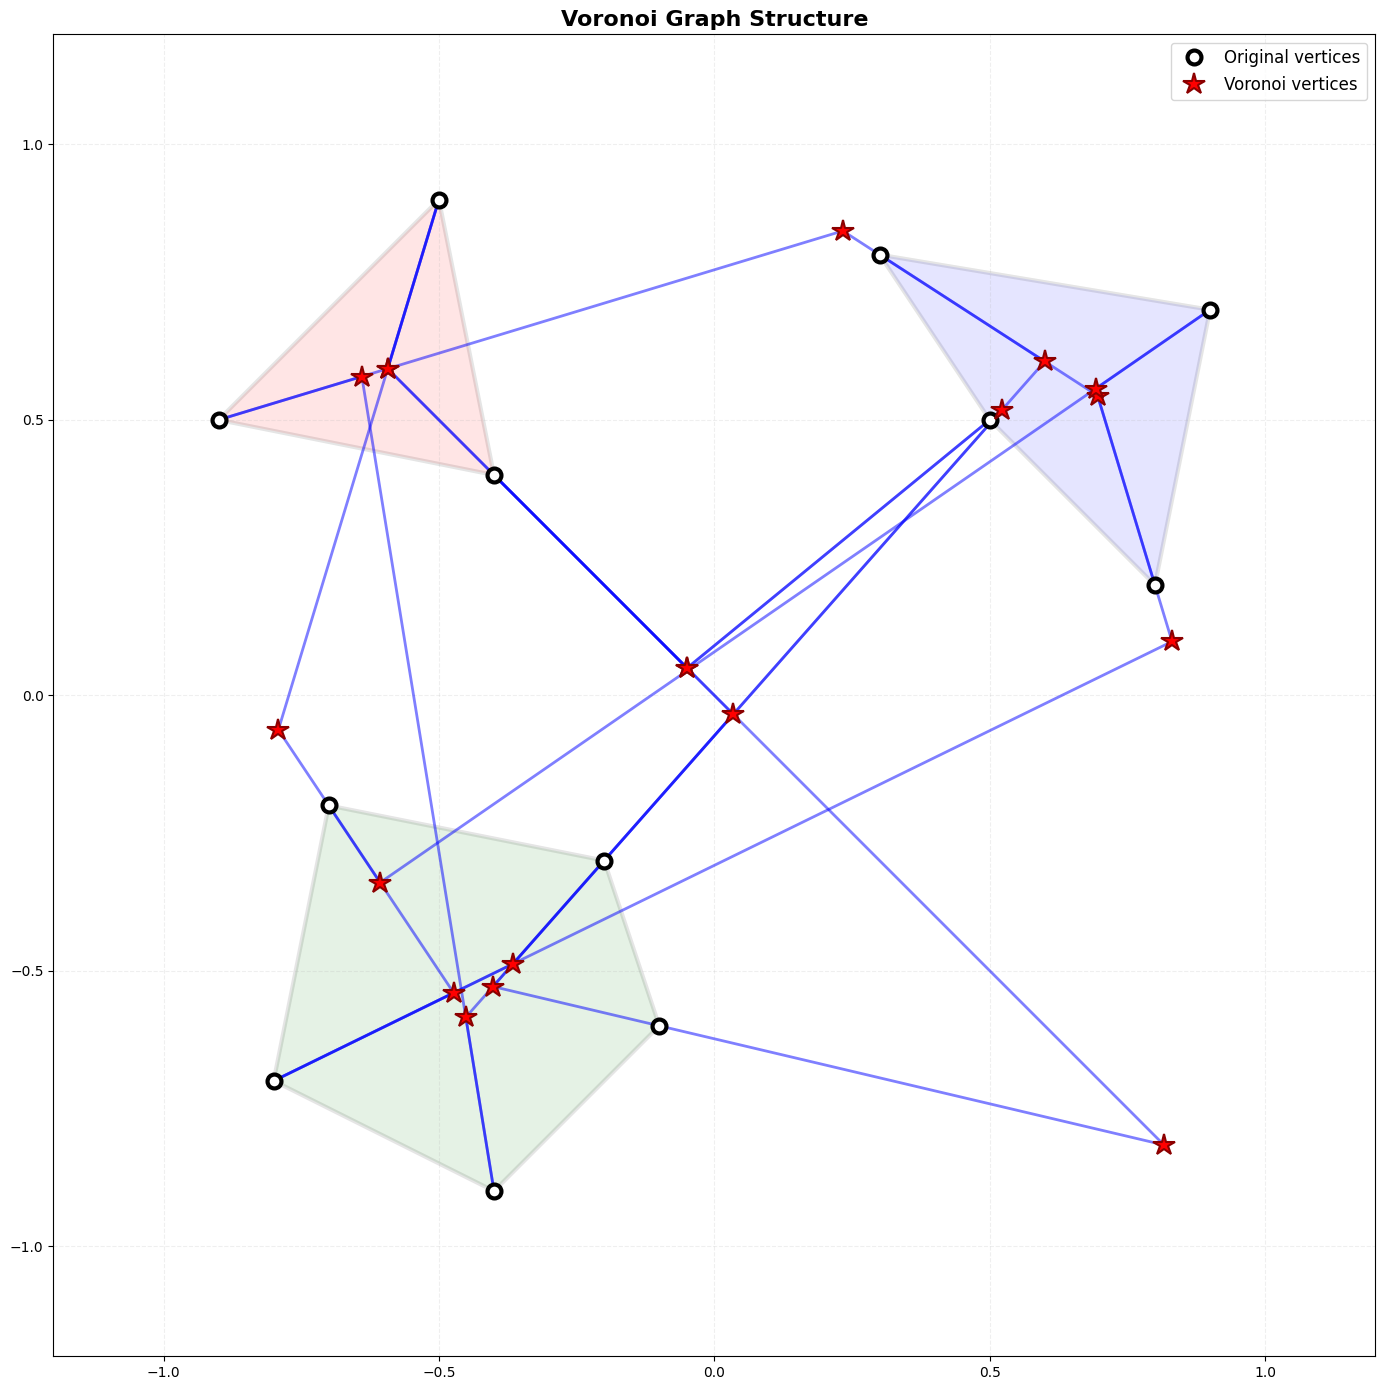

In [40]:
# Build graph
graph = voronoi.build_voronoi_graph(intersection_data)

print(f"\nVoronoi Graph:")
print(f"  Total vertices: {graph['num_original']} original + {graph['num_voronoi']} Voronoi")
print(f"  Total edges: {len(graph['edges'])}")

# Visualize graph
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

# Draw polygons
for shape_name, vertices in shapes.items():
    polygon = MplPolygon(vertices, facecolor=colors[shape_name], 
                        edgecolor='black', alpha=0.1, linewidth=3)
    ax.add_patch(polygon)

# Draw graph edges
all_vertices = graph['vertices'].cpu().numpy()
for v1_idx, v2_idx in graph['edges']:
    v1 = all_vertices[v1_idx]
    v2 = all_vertices[v2_idx]
    ax.plot([v1[0], v2[0]], [v1[1], v2[1]], 'b-', alpha=0.5, linewidth=2, zorder=5)

# Draw vertices
original_verts = all_vertices[:graph['num_original']]
ax.plot(original_verts[:, 0], original_verts[:, 1], 'ko', 
       markersize=10, zorder=10, markerfacecolor='white',
       markeredgewidth=3, label='Original vertices')

voronoi_verts = all_vertices[graph['num_original']:]
ax.plot(voronoi_verts[:, 0], voronoi_verts[:, 1], 'r*', 
       markersize=16, zorder=11, label='Voronoi vertices',
       markeredgecolor='darkred', markeredgewidth=1.5)

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.grid(True, alpha=0.2, linestyle='--')
ax.legend(loc='upper right', fontsize=12)
ax.set_title('Voronoi Graph Structure', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


## Step 7: Extract Edge Voronoi Cells

Determine which Voronoi vertices belong to which original polygon edge.


In [41]:
# Get edge-to-Voronoi mapping
edge_to_voronoi = voronoi.get_edge_voronoi_cells()

print(f"\nEdge Voronoi Cells:")
print(f"{'='*60}")

for edge_idx, voronoi_indices in edge_to_voronoi.items():
    edge = voronoi.edges[edge_idx].cpu().numpy()
    print(f"Edge {edge_idx}: {len(voronoi_indices)} Voronoi vertices")
    if len(voronoi_indices) > 0:
        print(f"  Voronoi vertices: {voronoi_indices}")


ValueError: Must run march_rays() first

## Step 8: Complete Edge Voronoi Diagram

Final visualization showing each edge with its Voronoi cell.


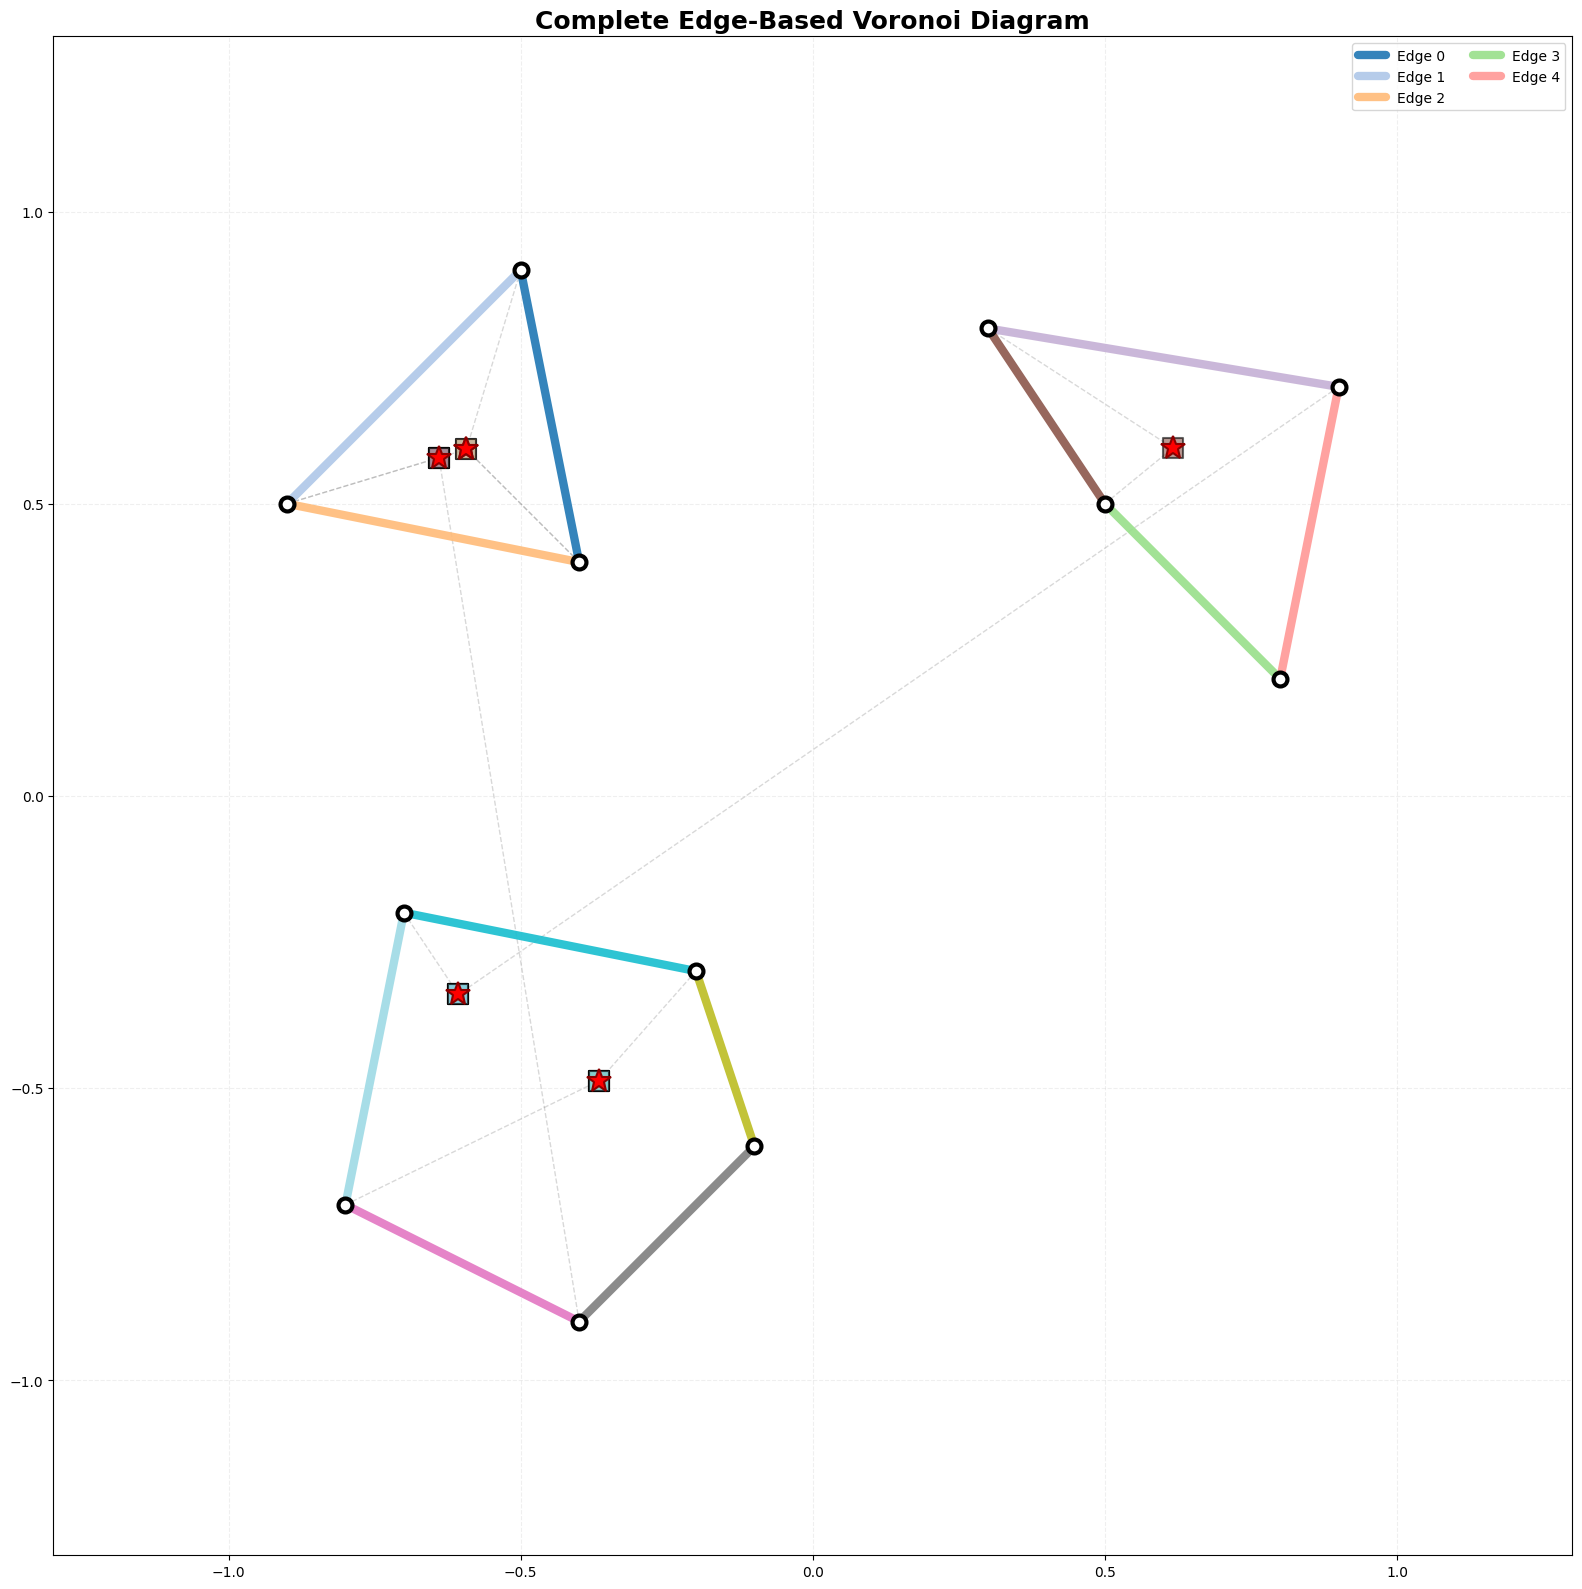


✓ Ray marching algorithm demonstration complete!

Key Result: Each of 12 edges has its own Voronoi cell!


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16))

# Generate colors for each edge
num_edges = len(edge_to_voronoi)
edge_colors = plt.cm.tab20(np.linspace(0, 1, num_edges))

all_vertices = graph['vertices'].cpu().numpy()
num_original = graph['num_original']

# Draw Voronoi regions for each edge
for edge_idx, voronoi_indices in edge_to_voronoi.items():
    if len(voronoi_indices) > 0:
        vor_verts = [all_vertices[num_original + i] for i in voronoi_indices]
        vor_verts = np.array(vor_verts)
        ax.scatter(vor_verts[:, 0], vor_verts[:, 1], 
                  c=[edge_colors[edge_idx]], s=200, alpha=0.6, 
                  marker='s', edgecolor='black', linewidth=1.5, zorder=8)

# Draw original polygon edges (thick)
for edge_idx in range(num_edges):
    edge = voronoi.edges[edge_idx].cpu().numpy()
    ax.plot([edge[0, 0], edge[1, 0]], [edge[0, 1], edge[1, 1]], 
           color=edge_colors[edge_idx], linewidth=6, alpha=0.9, 
           zorder=10, solid_capstyle='round',
           label=f'Edge {edge_idx}' if edge_idx < 5 else '')

# Draw graph edges (thin)
for v1_idx, v2_idx in graph['edges']:
    v1, v2 = all_vertices[v1_idx], all_vertices[v2_idx]
    ax.plot([v1[0], v2[0]], [v1[1], v2[1]], 'gray', 
           alpha=0.3, linewidth=1, zorder=5, linestyle='--')

# Draw vertices
original_verts = all_vertices[:num_original]
ax.plot(original_verts[:, 0], original_verts[:, 1], 'ko', 
       markersize=10, zorder=15, markerfacecolor='white', markeredgewidth=3)

voronoi_verts = all_vertices[num_original:]
ax.plot(voronoi_verts[:, 0], voronoi_verts[:, 1], 'r*', 
       markersize=18, zorder=16, markeredgecolor='darkred', markeredgewidth=1.5)

ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_aspect('equal')
ax.grid(True, alpha=0.2, linestyle='--')
ax.legend(loc='upper right', fontsize=10, ncol=2)
ax.set_title('Complete Edge-Based Voronoi Diagram', fontsize=18, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Ray marching algorithm demonstration complete!")
print(f"\nKey Result: Each of {num_edges} edges has its own Voronoi cell!")


## Summary

### What We Built

This notebook demonstrated a **ray marching algorithm** for computing edge-based Voronoi diagrams where each polygon **edge** (not vertex) gets its own Voronoi cell.

### Key Steps

1. **Graph Extraction**: Parse polygons into vertices, edges, and connectivity
2. **Normal Computation**: Compute average normals at each vertex from incident edges
3. **Ray Initialization**: Launch rays from each vertex in normal direction
4. **Parallel Marching**: March all rays simultaneously, step by step
5. **Collision Detection**: Check for ray-ray collisions within circular radius
6. **Intersection Computation**: Compute exact intersection points when rays collide
7. **Graph Construction**: Build Voronoi graph from original + Voronoi vertices
8. **Cell Assignment**: Map Voronoi vertices back to their corresponding edges

### Advantages

- ✅ **Fully parallel** - All rays march simultaneously (GPU-ready)
- ✅ **Analytical** - Exact intersection computation (no grid discretization)
- ✅ **Efficient** - O(n²) collision detection with spatial hashing potential
- ✅ **Extensible to 3D** - Same algorithm works for triangles with sphere collision

### Next Steps: Neural Network Initialization

The Voronoi structure can initialize SDFs analytically:

```python
# Each edge → One ReLU neuron
for edge_idx, edge in enumerate(edges):
    direction = edge[1] - edge[0]
    normal = [-direction[1], direction[0]]  # Perpendicular
    weight = normalize(normal)
    bias = -dot(weight, midpoint(edge))
    
    # This defines: relu(dot(weight, x) + bias)
    # Which is the signed distance to the edge!
```

This enables **analytic construction** of implicit representations!
